# 뉴스 카테고리 다중분류

### 0. 라이브러리 버전 확인

In [5]:
import tensorflow
import matplotlib
import seaborn 
import numpy 
import pandas
import sklearn

print(tensorflow.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(sklearn.__version__)

2.6.0
3.4.3
0.11.2
1.21.4
1.3.3
1.0


### 1. 터미널에 필요한 디렉토리 생성

In [6]:
# $ mkdir -p ~/aiffel/reuters_classifiaction

### 2. 데이터 다운로드

In [7]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## < 1. 모든 단어 사용 >

In [8]:
# 전체 단어 개수 확인
# Reuters 데이터셋 로드 (num_words는 None이 기본값, 즉 모든 단어를 불러옴)
(x_train, y_train), (x_test, y_test) = reuters.load_data()

# 데이터셋에서 사용된 고유한 단어 수 (단어 인덱스에서 최대 값 확인)
word_index = reuters.get_word_index()

# 단어 수 출력
num_words = len(word_index)
print(f'고유한 단어 수: {num_words}')

565248/550378 [==============================] - 0s 0us/step
고유한 단어 수: 30979


In [9]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [10]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


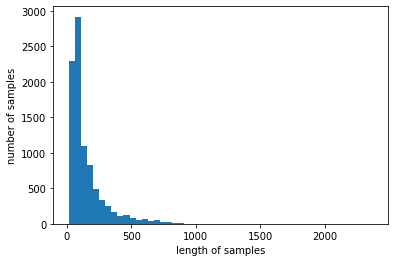

In [11]:
# 데이터 분포 확인
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

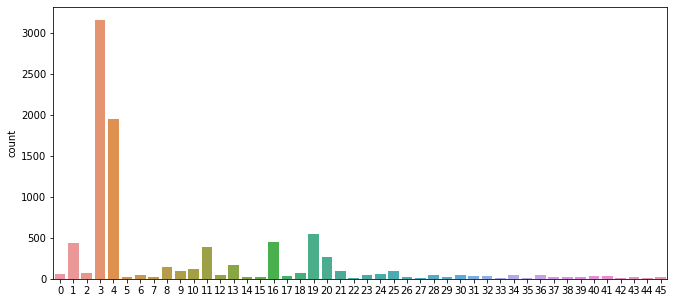

In [12]:
# 클래스 분포 확인
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [13]:
# 데이터 숫자->텍스트로 복원
index_to_word = { index+3 : word for word, index in word_index.items() }
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [14]:
#전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [15]:
#test데이터도 변환
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


### 3. 벡터화

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

##### Document Term Matrix, DTM은 사이킷런의 CountVectorizer()를 통해서 생성

In [17]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


##### TF-IDF Matrix는 사이킷런의 TfidfTransformer()를 통해서 생성

In [18]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


In [19]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

### < 1.모든 단어- 1) 나이브 베이즈 > 나이브 베이즈 분류기는 사이킷런의 MultinomialNB()를 통해 사용

In [20]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

In [24]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.5997328584149599
F1-score (weighted): 0.5045670886188423


### < 1.모든 단어- 2) CNB > 클래스 불균형일 때 나이브 베이즈의 한계 보완

In [29]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [31]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.7649154051647373
F1-score (weighted): 0.7346534179503126


### < 1.모든 단어- 3) 로지스틱 회귀 > 소프트맥스 함수 사용한 다중 클래스 분류 알고리즘

In [32]:
# 10분 정도 소요됩니다.
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [33]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.8165627782724845
F1-score (weighted): 0.8114428402876209


### < 1.모든 단어- 4) 선형 서포트벡터머신 > 이진 분류지만 일대 다로 학습

In [34]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [35]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.7938557435440784
F1-score (weighted): 0.7906023554328733


### < 1.모든 단어- 5) 결정 트리 > DTM, TF-IDF 행렬같이 고차원, 희소 데이터에는 성능 미비

In [36]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [37]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.6211041852181657
F1-score (weighted): 0.5769283128518846


### < 1.모든 단어- 6) 랜덤 포레스트 > 결정 트리를 사용한 앙상블 모델

In [38]:
#estimator를 5로 설정하고 random_state를 0으로 설정한 RandomForestClassifier를 선언해주세요.
#참고자료 : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
# RandomForestClassifier 선언
forest = RandomForestClassifier(n_estimators=5, random_state=0)
# 모델 학습
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [39]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.6544968833481746
F1-score (weighted): 0.6225909375608356


### < 1.모든 단어- 7) 그래디언트 부스팅 트리 >
### 여러 결정 트리를 묶어 사용한 앙상블 모델결, 랜덤 포레스트와 달리 이전 트리의 오차 보완하며 순차적으로 트리 만듦

In [40]:
# 15분 정도 소요될 수 있습니다.
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [41]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.7702582368655387
F1-score (weighted): 0.7641672650539437


### < 1.모든 단어- 8) 보팅 > 여러 모델의 결과물 중에 투표로 결정

In [42]:
# 20분 이상 소요
# 조건 1: 로지스틱 회귀 (패널티는 'L2'로 설정)
log_clf = LogisticRegression(penalty='l2', solver='lbfgs', random_state=0)
# 조건 2: Complement Naive Bayes Classifier
cnb_clf = ComplementNB()
# 조건 3: Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=0)
# VotingClassifier 설정 (soft voting)
voting_classifier = VotingClassifier(
    estimators=[
        ('log_clf', log_clf),
        ('cnb_clf', cnb_clf),
        ('gb_clf', gb_clf)
    ],
    voting='soft'
)

# 모델 학습
voting_classifier.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('log_clf', LogisticRegression(random_state=0)),
                             ('cnb_clf', ComplementNB()),
                             ('gb_clf',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')

In [43]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.8000890471950134
F1-score (weighted): 0.7944945456027671


### 모델 별 정확도 순위
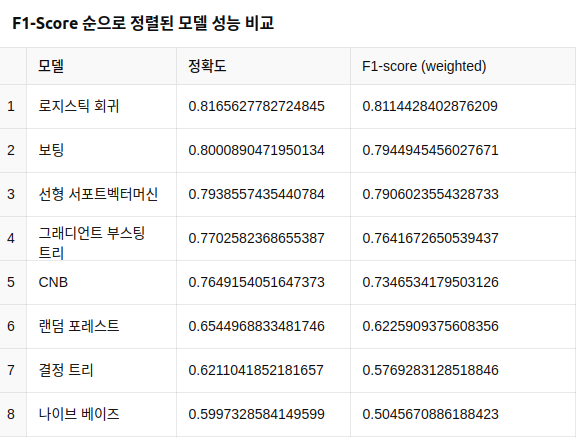

## 2. 빈도수 상위 5,000개의 단어만 사용

In [45]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [46]:
# 데이터 숫자->텍스트로 복원
index_to_word = { index+3 : word for word, index in word_index.items() }
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [47]:
#전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [48]:
#test데이터도 변환
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

In [49]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

### < 2. 5000 단어- 1) 나이브 베이즈 > 나이브 베이즈 분류기는 사이킷런의 MultinomialNB()를 통해 사용

In [50]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [51]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.6731967943009796
F1-score (weighted): 0.6012501291711391


### < 2. 5000 단어- 2) CNB > 클래스 불균형일 때 나이브 베이즈의 한계 보완

In [52]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [53]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.7707034728406055
F1-score (weighted): 0.7458990404916549


### < 2. 5000 단어- 3) 로지스틱 회귀 > 소프트맥스 함수 사용한 다중 클래스 분류 알고리즘

In [54]:
# 10분 정도 소요됩니다.
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [55]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.8036509349955476
F1-score (weighted): 0.7985602317931111


### < 2. 5000 단어- 4) 선형 서포트벡터머신 > 이진 분류지만 일대 다로 학습

In [56]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [57]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.7751558325912734
F1-score (weighted): 0.7710288271890536


### < 2. 5000 단어- 5) 결정 트리 > DTM, TF-IDF 행렬같이 고차원, 희소 데이터에는 성능 미비

In [58]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [59]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.6179875333926982
F1-score (weighted): 0.5729970881280324


### < 2. 5000 단어- 6) 랜덤 포레스트 > 결정 트리를 사용한 앙상블 모델

In [60]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [61]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.701246660730187
F1-score (weighted): 0.6770217603524399


### < 2. 5000 단어- 7) 그래디언트 부스팅 트리 >

In [62]:
# 15분 정도 소요될 수 있습니다.
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [63]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.767586821015138
F1-score (weighted): 0.7662475269931749


### < 2. 5000 단어- 8) 보팅 > 여러 모델의 결과물 중에 투표로 결정

In [64]:
# 20분 이상 소요
# 조건 1: 로지스틱 회귀 (패널티는 'L2'로 설정)
log_clf = LogisticRegression(penalty='l2', solver='lbfgs', random_state=0)
# 조건 2: Complement Naive Bayes Classifier
cnb_clf = ComplementNB()
# 조건 3: Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=0)
# VotingClassifier 설정 (soft voting)
voting_classifier = VotingClassifier(
    estimators=[
        ('log_clf', log_clf),
        ('cnb_clf', cnb_clf),
        ('gb_clf', gb_clf)
    ],
    voting='soft'
)

# 모델 학습
voting_classifier.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('log_clf', LogisticRegression(random_state=0)),
                             ('cnb_clf', ComplementNB()),
                             ('gb_clf',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')

In [65]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.7960819234194123
F1-score (weighted): 0.7931448977062081


### 모델 정확도 순위

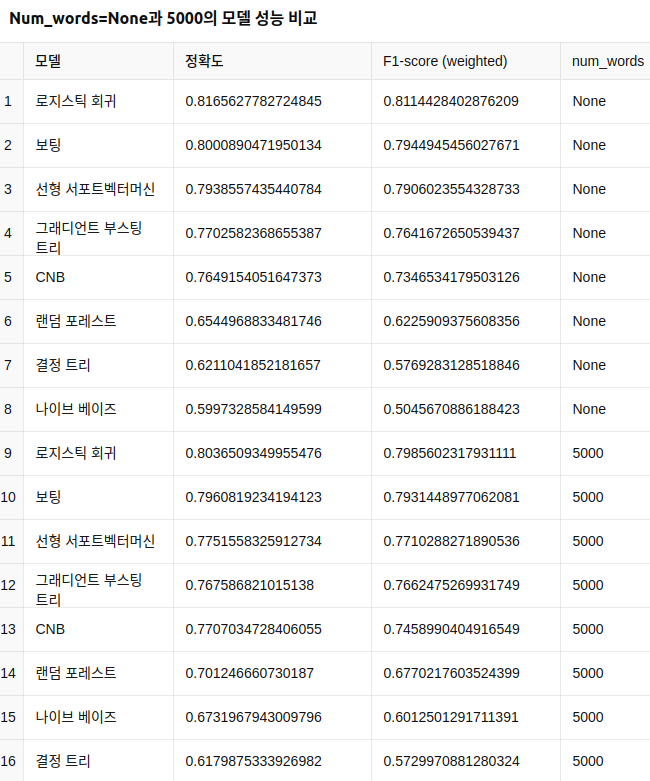

## 3. 직접 단어 개수를 설정해서 사용

In [66]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=2500, test_split=0.2)

In [67]:
# 데이터 숫자->텍스트로 복원
index_to_word = { index+3 : word for word, index in word_index.items() }
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of <unk> co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and <unk> operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [68]:
#전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [69]:
#test데이터도 변환
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

In [70]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

### < 3. 2500 단어- 1) 나이브 베이즈 > 나이브 베이즈 분류기는 사이킷런의 MultinomialNB()를 통해 사용

In [71]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [72]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.6905609973285841
F1-score (weighted): 0.6356933283152083


### < 3. 2500 단어- 2) CNB > 클래스 불균형일 때 나이브 베이즈의 한계 보완

In [73]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [74]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.7609082813891362
F1-score (weighted): 0.7332431109256139


### < 3. 2500 단어- 3) 로지스틱 회귀 > 소프트맥스 함수 사용한 다중 클래스 분류 알고리즘

In [75]:
# 10분 정도 소요됩니다.
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [76]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.7831700801424755
F1-score (weighted): 0.7786708346289651


### < 3. 2500 단어- 4) 선형 서포트벡터머신 > 이진 분류지만 일대 다로 학습

In [77]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [78]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.7457702582368655
F1-score (weighted): 0.7422538760372324


### < 3. 2500 단어- 5) 결정 트리 > DTM, TF-IDF 행렬같이 고차원, 희소 데이터에는 성능 미비

In [79]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [80]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.6260017809439002
F1-score (weighted): 0.5793740833103838


### < 3. 2500 단어- 6) 랜덤 포레스트 > 결정 트리를 사용한 앙상블 모델

In [81]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [82]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.705253784505788
F1-score (weighted): 0.6816910329790441


### < 3. 2500 단어- 7) 그래디언트 부스팅 트리 >

In [83]:
# 15분 정도 소요될 수 있습니다.
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [84]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.7666963490650045
F1-score (weighted): 0.7639437605488705


### < 3. 2500 단어- 8) 보팅 > 여러 모델의 결과물 중에 투표로 결정

In [85]:
# 20분 이상 소요
# 조건 1: 로지스틱 회귀 (패널티는 'L2'로 설정)
log_clf = LogisticRegression(penalty='l2', solver='lbfgs', random_state=0)
# 조건 2: Complement Naive Bayes Classifier
cnb_clf = ComplementNB()
# 조건 3: Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=0)
# VotingClassifier 설정 (soft voting)
voting_classifier = VotingClassifier(
    estimators=[
        ('log_clf', log_clf),
        ('cnb_clf', cnb_clf),
        ('gb_clf', gb_clf)
    ],
    voting='soft'
)

# 모델 학습
voting_classifier.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('log_clf', LogisticRegression(random_state=0)),
                             ('cnb_clf', ComplementNB()),
                             ('gb_clf',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')

In [86]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
f1 = f1_score(y_test, predicted, average='weighted')
print("F1-score (weighted):", f1)

정확도: 0.794746215494212
F1-score (weighted): 0.7899061118662642


### 모델 별 성능 비교
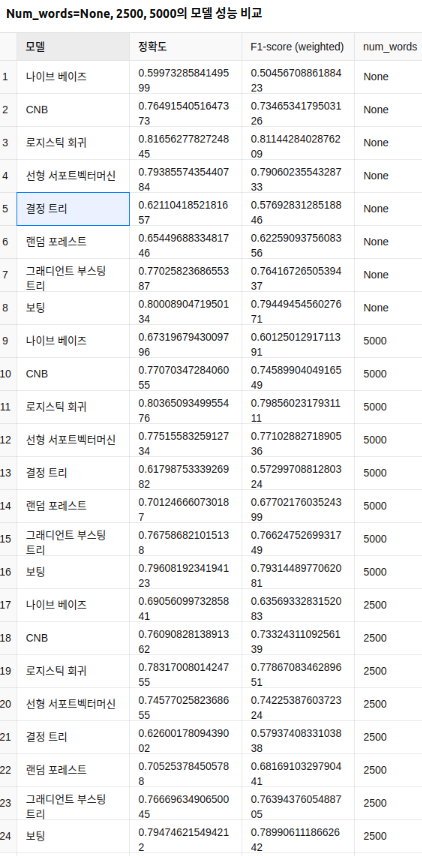

## 4. 딥러닝으로 훈련하기

### < 1. RNN 사용하기, 최대문장길이=300, 드랍아웃O >

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
from sklearn.metrics import accuracy_score, f1_score

# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000)

# 패딩을 적용하여 입력 길이 통일 (padding='pre', max_len=300으로 설정)
max_len = 300  # 최대 문장 길이 설정
x_train_padded = pad_sequences(x_train, maxlen=max_len, padding='pre')
x_test_padded = pad_sequences(x_test, maxlen=max_len, padding='pre')

# 라벨을 원-핫 인코딩으로 변환
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# RNN 모델 정의 (드롭아웃 추가)
model = Sequential()

# 1. Embedding Layer
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))

# 2. 첫 번째 LSTM 층 (드롭아웃 추가, return_sequences=True)
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))  # 드롭아웃 추가

# 3. 두 번째 LSTM 층 (드롭아웃 추가)
model.add(LSTM(128))
model.add(Dropout(0.2))  # 드롭아웃 추가

# 4. 밀집층(Dense Layer)
model.add(Dense(64, activation='relu'))

# 5. 출력층
model.add(Dense(46, activation='softmax'))  # 46개의 카테고리를 분류

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(x_train_padded, y_train_one_hot, epochs=10, batch_size=64, validation_split=0.2)

# 모델 평가
y_pred = model.predict(x_test_padded)
y_pred_classes = y_pred.argmax(axis=1)

# 정확도와 F1-score 계산
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("RNN 모델 (드롭아웃 추가, max_len=300) 정확도:", accuracy)
print("RNN 모델 (드롭아웃 추가, max_len=300) F1-score (weighted):", f1)


Epoch 1/10
113/113 [==============================] - 31s 34ms/step - loss: 2.5720 - accuracy: 0.3343 - val_loss: 2.4632 - val_accuracy: 0.3450
Epoch 2/10
113/113 [==============================] - 3s 27ms/step - loss: 2.5401 - accuracy: 0.3236 - val_loss: 2.4134 - val_accuracy: 0.3450
Epoch 3/10
113/113 [==============================] - 3s 27ms/step - loss: 2.3269 - accuracy: 0.4011 - val_loss: 2.0779 - val_accuracy: 0.4886
Epoch 4/10
113/113 [==============================] - 3s 27ms/step - loss: 2.0252 - accuracy: 0.5005 - val_loss: 1.9406 - val_accuracy: 0.4997
Epoch 5/10
113/113 [==============================] - 3s 27ms/step - loss: 1.8937 - accuracy: 0.5042 - val_loss: 1.7823 - val_accuracy: 0.5303
Epoch 6/10
113/113 [==============================] - 3s 27ms/step - loss: 1.7623 - accuracy: 0.5386 - val_loss: 1.7678 - val_accuracy: 0.5320
Epoch 7/10
113/113 [==============================] - 3s 27ms/step - loss: 1.6932 - accuracy: 0.5601 - val_loss: 1.7437 - val_accuracy: 0.544

### < 1. RNN 사용하기, 최대문장길이=300, 드랍아웃X >

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
from sklearn.metrics import accuracy_score, f1_score

# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000)

# 패딩을 적용하여 입력 길이 통일 (padding='pre', max_len=300으로 설정)
max_len = 300  # 최대 문장 길이 설정
x_train_padded = pad_sequences(x_train, maxlen=max_len, padding='pre')
x_test_padded = pad_sequences(x_test, maxlen=max_len, padding='pre')

# 라벨을 원-핫 인코딩으로 변환
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# RNN 모델 정의 (드롭아웃 제외)
model = Sequential()

# 1. Embedding Layer
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))

# 2. 첫 번째 LSTM 층 (return_sequences=True)
model.add(LSTM(128, return_sequences=True))

# 3. 두 번째 LSTM 층 (return_sequences=False, 기본 값)
model.add(LSTM(128))

# 4. 밀집층(Dense Layer)
model.add(Dense(64, activation='relu'))

# 5. 출력층
model.add(Dense(46, activation='softmax'))  # 46개의 카테고리를 분류

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(x_train_padded, y_train_one_hot, epochs=10, batch_size=64, validation_split=0.2)

# 모델 평가
y_pred = model.predict(x_test_padded)
y_pred_classes = y_pred.argmax(axis=1)

# 정확도와 F1-score 계산
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("RNN 모델 (드롭아웃 제외, max_len=300) 정확도:", accuracy)
print("RNN 모델 (드롭아웃 제외, max_len=300) F1-score (weighted):", f1)


Epoch 1/10
113/113 [==============================] - 6s 36ms/step - loss: 2.2376 - accuracy: 0.4483 - val_loss: 1.7716 - val_accuracy: 0.5387
Epoch 2/10
113/113 [==============================] - 3s 27ms/step - loss: 1.8261 - accuracy: 0.5218 - val_loss: 1.7707 - val_accuracy: 0.5392
Epoch 3/10
113/113 [==============================] - 3s 27ms/step - loss: 1.6915 - accuracy: 0.5644 - val_loss: 1.6905 - val_accuracy: 0.5665
Epoch 4/10
113/113 [==============================] - 3s 27ms/step - loss: 1.6826 - accuracy: 0.5610 - val_loss: 1.8343 - val_accuracy: 0.5370
Epoch 5/10
113/113 [==============================] - 3s 27ms/step - loss: 1.6029 - accuracy: 0.5864 - val_loss: 1.6286 - val_accuracy: 0.5932
Epoch 6/10
113/113 [==============================] - 3s 27ms/step - loss: 1.5108 - accuracy: 0.6159 - val_loss: 1.6268 - val_accuracy: 0.5971
Epoch 7/10
113/113 [==============================] - 3s 27ms/step - loss: 1.4113 - accuracy: 0.6362 - val_loss: 1.5910 - val_accuracy: 0.6027

### < 2. RNN 사용하기, 최대문장길이=200, 드랍아웃x >

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
from sklearn.metrics import accuracy_score, f1_score

# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000)

# 패딩을 적용하여 입력 길이 통일 (padding='pre', max_len=200으로 설정)
max_len = 200  # 최대 문장 길이 설정
x_train_padded = pad_sequences(x_train, maxlen=max_len, padding='pre')
x_test_padded = pad_sequences(x_test, maxlen=max_len, padding='pre')

# 라벨을 원-핫 인코딩으로 변환
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# RNN 모델 정의 (드롭아웃 제외)
model = Sequential()

# 1. Embedding Layer
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))

# 2. 첫 번째 LSTM 층 (return_sequences=True)
model.add(LSTM(128, return_sequences=True))

# 3. 두 번째 LSTM 층 (return_sequences=False, 기본 값)
model.add(LSTM(128))

# 4. 밀집층(Dense Layer)
model.add(Dense(64, activation='relu'))

# 5. 출력층
model.add(Dense(46, activation='softmax'))  # 46개의 카테고리를 분류

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(x_train_padded, y_train_one_hot, epochs=10, batch_size=64, validation_split=0.2)

# 모델 평가
y_pred = model.predict(x_test_padded)
y_pred_classes = y_pred.argmax(axis=1)

# 정확도와 F1-score 계산
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("RNN 모델 (드롭아웃 제외, max_len=200) 정확도:", accuracy)
print("RNN 모델 (드롭아웃 제외, max_len=200) F1-score (weighted):", f1)


Epoch 1/10
113/113 [==============================] - 5s 26ms/step - loss: 2.2635 - accuracy: 0.4255 - val_loss: 1.9088 - val_accuracy: 0.5053
Epoch 2/10
113/113 [==============================] - 2s 19ms/step - loss: 1.7688 - accuracy: 0.5314 - val_loss: 1.8549 - val_accuracy: 0.4502
Epoch 3/10
113/113 [==============================] - 2s 19ms/step - loss: 1.6641 - accuracy: 0.5677 - val_loss: 1.6889 - val_accuracy: 0.5698
Epoch 4/10
113/113 [==============================] - 2s 20ms/step - loss: 1.5483 - accuracy: 0.6033 - val_loss: 1.6389 - val_accuracy: 0.5815
Epoch 5/10
113/113 [==============================] - 2s 19ms/step - loss: 1.5614 - accuracy: 0.6057 - val_loss: 2.1479 - val_accuracy: 0.4546
Epoch 6/10
113/113 [==============================] - 2s 20ms/step - loss: 1.7511 - accuracy: 0.5595 - val_loss: 1.7569 - val_accuracy: 0.5470
Epoch 7/10
113/113 [==============================] - 2s 20ms/step - loss: 1.5502 - accuracy: 0.6003 - val_loss: 1.6371 - val_accuracy: 0.5754

### < 2. RNN 사용하기, 최대문장길이=400, 드랍아웃? >

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
from sklearn.metrics import accuracy_score, f1_score

# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000)

# 패딩을 적용하여 입력 길이 통일 (padding='pre', max_len=400으로 설정)
max_len = 400  # 최대 문장 길이 설정
x_train_padded = pad_sequences(x_train, maxlen=max_len, padding='pre')
x_test_padded = pad_sequences(x_test, maxlen=max_len, padding='pre')

# 라벨을 원-핫 인코딩으로 변환
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# RNN 모델 정의 (드롭아웃 제외)
model = Sequential()

# 1. Embedding Layer
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))

# 2. 첫 번째 LSTM 층 (return_sequences=True)
model.add(LSTM(128, return_sequences=True))

# 3. 두 번째 LSTM 층 (return_sequences=False, 기본 값)
model.add(LSTM(128))

# 4. 밀집층(Dense Layer)
model.add(Dense(64, activation='relu'))

# 5. 출력층
model.add(Dense(46, activation='softmax'))  # 46개의 카테고리를 분류

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(x_train_padded, y_train_one_hot, epochs=10, batch_size=64, validation_split=0.2)

# 모델 평가
y_pred = model.predict(x_test_padded)
y_pred_classes = y_pred.argmax(axis=1)

# 정확도와 F1-score 계산
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("RNN 모델 (드롭아웃 제외, max_len=400) 정확도:", accuracy)
print("RNN 모델 (드롭아웃 제외, max_len=400) F1-score (weighted):", f1)


Epoch 1/10
113/113 [==============================] - 7s 42ms/step - loss: 2.5738 - accuracy: 0.3390 - val_loss: 2.3147 - val_accuracy: 0.3450
Epoch 2/10
113/113 [==============================] - 4s 36ms/step - loss: 1.9687 - accuracy: 0.4900 - val_loss: 1.7931 - val_accuracy: 0.5253
Epoch 3/10
113/113 [==============================] - 4s 36ms/step - loss: 1.7725 - accuracy: 0.5296 - val_loss: 1.7601 - val_accuracy: 0.5431
Epoch 4/10
113/113 [==============================] - 4s 37ms/step - loss: 1.6541 - accuracy: 0.5692 - val_loss: 1.6806 - val_accuracy: 0.5776
Epoch 5/10
113/113 [==============================] - 4s 37ms/step - loss: 1.5638 - accuracy: 0.5960 - val_loss: 1.6667 - val_accuracy: 0.5754
Epoch 6/10
113/113 [==============================] - 4s 37ms/step - loss: 1.4534 - accuracy: 0.6157 - val_loss: 1.5698 - val_accuracy: 0.6177
Epoch 7/10
113/113 [==============================] - 4s 37ms/step - loss: 1.3494 - accuracy: 0.6497 - val_loss: 1.5285 - val_accuracy: 0.6171

회고

다중 분류 모델에는 보팅, 선형회귀, lsvm이 좋다는 것을 알게되었다.
그 이유는 보팅이 여러 모델의 성능을 비교 분석해서 최적의 결과를 내는 것이기도 하고 
과적합을 방지해주기 때문일까..?